#### why 400K
#### normalize new data?
10/7 abstract
10/14 

In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
import random

## load data

In [2]:
data = pd.read_csv('psam_pusa.csv')

In [3]:
print('The dimentionality of dataframe is {}.'.format(data.shape))
df_a = data.copy()
print('The dimentionality of copied dataframe is {}.'.format(df_a.shape))
# df_a.head()
# df_a.tail()

The dimentionality of dataframe is (4691835, 286).
The dimentionality of copied dataframe is (4691835, 286).


## define variables

In [4]:
# list(df_a)
TARGET = 'HINS4'
NUM_VAR = ['AGEP', 'INTP', 'POVPIP', 'PINCP']
CAT_VAR = ['REGION','DIVISION','ST','ADJINC','COW','MAR','DDRS','DEAR','DOUT','DPHY','DRAT','SEX','RAC1P']

PROTECTED_VAR = 'PINCP'
PROTECTED_THRE = 20000
FAIRNESS_THRE = 
display(df_a[TARGET].value_counts().rename_axis('unique_values').\
        reset_index(name='counts'))

display(df_a[NUM_VAR].describe())

SyntaxError: invalid syntax (<ipython-input-4-2118477ab091>, line 8)

## deal with na

In [ ]:
# df_a[IND_VAR].isnull().sum()
df_a_nna=df_a[NUM_VAR + CAT_VAR + [TARGET]].dropna(axis=0, how='any')
print('The dimentionality of no NA dataframe is {}.'.format(df_a_nna.shape))
display(df_a_nna[TARGET].value_counts().rename_axis('unique_values').\
        reset_index(name='counts'))

In [6]:
df_a_nna.head()

,AGEP,INTP,POVPIP,PINCP,REGION,DIVISION,ST,ADJINC,COW,MAR,DDRS,DEAR,DOUT,DPHY,DRAT,SEX,RAC1P,HINS4
83,63,0.0,462.0,25800.0,3,6,1,1061971,1.0,1,2.0,2,2.0,2.0,5.0,1,2,2
249,59,0.0,501.0,75400.0,3,6,1,1061971,1.0,3,2.0,1,2.0,2.0,2.0,1,1,2
309,51,0.0,501.0,63150.0,3,6,1,1061971,4.0,5,2.0,2,2.0,2.0,5.0,1,2,2
598,57,700.0,501.0,87200.0,3,6,1,1061971,5.0,1,2.0,2,2.0,2.0,3.0,2,2,2
876,33,0.0,2.0,560.0,3,6,1,1061971,5.0,1,2.0,2,2.0,2.0,3.0,2,2,1


## deal with imbalance

In [ ]:
def keep_balance(df):
#     dft = df.copy()
    # keep balance by under-sampling
    df_0 = df[df[TARGET] == 2].sample(n=df[TARGET].value_counts()[1], random_state=1)
    df_1 = df[df[TARGET] == 1]
    balanced_all_df = pd.concat([df_0, df_1])
    # separate X and Y
    balanced_X = balanced_all_df.drop([TARGET], axis=1, inplace=False)
    balanced_Y = balanced_all_df[[TARGET]]
    print('Data shape of balanced_X is {}, data shape of balanced_Y is {}'.format(balanced_X.shape, balanced_Y.shape))
    return balanced_X, balanced_Y

In [8]:
bal_X, bal_Y = keep_balance(df_a_nna)

Data shape of balanced_X is (5452, 17), data shape of balanced_Y is (5452, 1)


## deal with categorical variables

In [9]:
def apply_one_hot(df, using_na = False):
    for v in CAT_VAR:
        df = pd.get_dummies(df, columns=[v], prefix = [v], dummy_na=using_na)
    print('One-hot encoding data shape:{}'.format(df.shape))
    return df

In [10]:
df_oh = apply_one_hot(bal_X)

One-hot encoding data shape:(5452, 69)


## split train and test

In [11]:
def split_train_test(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, \
                                                        test_size=0.3, random_state=777)
    print('The dimentionality of X_train is {}.'.format(X_train.shape))
    print('The dimentionality of X_test is {}.'.format(X_test.shape))
    print('The dimentionality of y_train is {}.'.format(y_train.shape))
    print('The dimentionality of y_test is {}.'.format(y_test.shape))
    return X_train, X_test, y_train, y_test

In [12]:
X_train, X_test, Y_train, Y_test = split_train_test(df_oh, bal_Y)

The dimentionality of X_train is (3816, 69).
The dimentionality of X_test is (1636, 69).
The dimentionality of y_train is (3816, 1).
The dimentionality of y_test is (1636, 1).


## standardizing for numeric variables

In [13]:
def cal_mean_var(X_train, X_test):
    train_prot_mean = X_train[PROTECTED_VAR].mean()
    train_prot_std = X_train[PROTECTED_VAR].std()
    return train_prot_mean, train_prot_std

In [14]:
tr_prot_mean, tr_prot_std = cal_mean_var(X_train, X_test)

In [15]:
def standardize_numeric_var(X_train, X_test, show = False):
    X_train_std = X_train.copy()
    X_test_std = X_test.copy()
    scaler = StandardScaler().fit(X_train_std[NUM_VAR].values)
    X_train_std[NUM_VAR] = scaler.transform(X_train_std[NUM_VAR].values)
    X_test_std[NUM_VAR] = scaler.transform(X_test_std[NUM_VAR].values) #NUM_VAR
    return X_train_std, X_test_std, scaler 

In [37]:
X_train_std, X_test_std, sc = standardize_numeric_var(X_train, X_test)

## calculate thre for protected variable

In [38]:
def cal_protect_thre(train_prot_mean, train_prot_std):
    # cal thre, standardization : (x - mean) / standard deviation
    return (PROTECTED_THRE - train_prot_mean) / train_prot_std

In [39]:
tr_prot_thre = cal_protect_thre(tr_prot_mean, tr_prot_std)

## train Logistic Regression model

In [40]:
lr = LogisticRegression()
lr.fit(X_train_std, Y_train)
pred = lr.predict(X_test_std)

print('Accurary : {}'.format(metrics.accuracy_score(Y_test, pred)))
print('Precision : {}'.format(metrics.precision_score(Y_test, pred)))
print('Recall : {}'.format(metrics.recall_score(Y_test, pred)))
print('F1 score : {}'.format(metrics.f1_score(Y_test, pred)))

Accurary : 0.6858190709046454
Precision : 0.6796116504854369
Recall : 0.691358024691358
F1 score : 0.6854345165238678


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## check fairness

In [41]:
def add_prot_binary(df, prot_thre):
    df['prot_binary'] = np.where(df[PROTECTED_VAR] < prot_thre, 1, 0)
    return df

In [42]:
X_train_std = add_prot_binary(X_train_std, tr_prot_thre)
X_train_std.head()

,AGEP,INTP,POVPIP,PINCP,REGION_1,REGION_3,REGION_4,DIVISION_1,DIVISION_5,DIVISION_6,...,RAC1P_1,RAC1P_2,RAC1P_3,RAC1P_4,RAC1P_5,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9,prot_binary
4308488,1.195164,-0.110778,-0.813609,-0.615532,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
3796541,2.039975,-0.110778,-0.294643,-0.682878,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
3837733,0.740266,-0.110778,1.042459,-0.427307,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4336678,1.065193,-0.110778,-0.874664,-0.579959,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4033519,1.000208,-0.110778,0.798240,0.082108,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


In [43]:
X_test_std = add_prot_binary(X_test_std, tr_prot_thre)
X_test_std.head()

,AGEP,INTP,POVPIP,PINCP,REGION_1,REGION_3,REGION_4,DIVISION_1,DIVISION_5,DIVISION_6,...,RAC1P_1,RAC1P_2,RAC1P_3,RAC1P_4,RAC1P_5,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9,prot_binary
1997981,-0.949357,-0.110778,0.383066,-0.225268,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4576662,0.155396,-0.110778,-2.016390,-0.947083,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
4430340,-0.429473,-0.110778,1.042459,0.144274,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1574040,0.805251,-0.110778,1.042459,0.923075,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4041661,0.870237,0.313042,0.547915,-0.107843,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


In [153]:
def check_fairness(df):
    pp_r = len(df[(df[TARGET] == 1) & (df['prot_binary'] == 1)]) / len(df)
    print('poor people that receive assistance: {:.4f}'.format(pp_r))
    np_r = len(df[(df[TARGET] == 1) & (df['prot_binary'] == 0)]) / len(df)
    print('people not poor that receive assistance: {:.4f}'.format(np_r))
    pp_nr = len(df[(df[TARGET] == 2) & (df['prot_binary'] == 1)]) / len(df)
    print('poor people that do not receive assistance: {:.4f}'.format(pp_nr))
    np_nr = len(df[(df[TARGET] == 2) & (df['prot_binary'] == 0)]) / len(df)
    print('people not poor that do not receive assistance: {:.4f}'.format(np_nr))
    print('----------------------------------------------------------')
    pp = len(df[(df['prot_binary'] == 1)]) / len(df)
    np = len(df[(df['prot_binary'] == 0)]) / len(df)
    print('% of poor receiving assistance: {:.4f}'.format(pp_r / (pp_r + pp_nr)))
    print('% of not poor receiving assistance: {:.4f}'.format(np_r / (np_r + np_nr)))
    print('fairgroup: pp is {:.4f}, np is {:.4f}, ratio is {:.4f}'.format(pp, np, min(pp/np, np/pp)))
    return pp, np

In [154]:
_X_test_std = X_test_std.copy()
_X_test_std[TARGET] = pd.Series(pred, index=X_test_std.index)
# X_test_std.head()
_, _ = check_fairness(_X_test_std)

poor people that receive assistance: 0.2335
people not poor that receive assistance: 0.2702
poor people that do not receive assistance: 0.0300
people not poor that do not receive assistance: 0.4664
----------------------------------------------------------
% of poor receiving assistance: 0.8863
% of not poor receiving assistance: 0.3668
fairgroup: pp is 0.2634, np is 0.7366, ratio is 0.3577


## get coef to rank importance, assign feature weight

In [53]:
lr_coef = sorted(list(zip(list(X_train_std.columns), lr.coef_[0])), key = lambda x: abs(x[1]), reverse = True)
n_var = len(lr_coef)
lr_coef = [lr_coef[i]+(n_var-i,) for i in range(n_var)]
lr_coef

[('RAC1P_5', -0.9337707759499346, 69),
 ('POVPIP', 0.7497455521901326, 68),
 ('MAR_2', -0.6278795034894344, 67),
 ('COW_8.0', 0.591045796890092, 66),
 ('RAC1P_7', 0.5034099788076951, 65),
 ('DRAT_5.0', -0.38863661242283654, 64),
 ('DOUT_1.0', -0.38823406396906324, 63),
 ('COW_9.0', -0.3867445153259451, 62),
 ('ST_10', -0.3765576942622894, 61),
 ('DPHY_1.0', -0.3744686821869857, 60),
 ('COW_7.0', -0.34333056121881894, 59),
 ('ST_15', 0.3403876891948603, 58),
 ('DDRS_2.0', -0.33211416479662076, 57),
 ('COW_4.0', 0.3282821781954607, 56),
 ('RAC1P_9', 0.30071064608010434, 55),
 ('RAC1P_4', -0.2993139885363804, 54),
 ('COW_6.0', -0.29584721991548857, 53),
 ('DRAT_6.0', -0.2804244523125726, 52),
 ('ADJINC_1061971', 0.26466004798153425, 51),
 ('DOUT_2.0', 0.2580322809100344, 50),
 ('DRAT_3.0', 0.25501998245337454, 49),
 ('MAR_3', 0.2500743569051006, 48),
 ('DPHY_2.0', 0.2442668991277372, 47),
 ('ADJINC_1011189', -0.23864063987157594, 46),
 ('DRAT_2.0', 0.22684129125170135, 45),
 ('RAC1P_8', 0

## generate new data

In [86]:
new_scores = []
for l in lr_coef:
    var, coef, weight = l
    # If a feature is positively correlated with Y, we rank data by the decreasing order.
    if coef >= 0:
        unique_vals = sorted(set(X_test_std[var]), reverse=True)
        n_unique_vals = len(unique_vals)
        unique_dict = dict(zip(unique_vals, map(lambda x: n_unique_vals-x, list(range(len(unique_vals))))))
        new_scores.append([unique_dict[x]*weight for x in X_test_std[var]])
    # if a feature has negative correlation, the the data is ranked in increasing order.
    else:
        unique_vals = sorted(set(X_test_std[var]), reverse=False)
        n_unique_vals = len(unique_vals)
        unique_dict = dict(zip(unique_vals, map(lambda x: n_unique_vals-x, list(range(len(unique_vals))))))
        new_scores.append([unique_dict[x]*weight for x in X_test_std[var]])

In [94]:
new_df = pd.DataFrame(new_scores).transpose()
new_df.columns = [i[0] for i in lr_coef]
print('The dimentionality of new dataframe is {}.'.format(new_df.shape))
new_df_with_y = pd.concat([new_df, X_test_std['prot_binary'].reset_index(drop=True)], axis=1)
new_df_with_y = pd.concat([new_df_with_y, Y_test.reset_index(drop=True)], axis=1)
new_df_with_y['pred'] = pred
print('The dimentionality of new dataframe with y is {}.'.format(new_df_with_y.shape))
new_df_with_y.head()

The dimentionality of new dataframe is (1636, 69).
The dimentionality of new dataframe with y is (1636, 72).


,RAC1P_5,POVPIP,MAR_2,COW_8.0,RAC1P_7,DRAT_5.0,DOUT_1.0,COW_9.0,ST_10,DPHY_1.0,...,MAR_4,ST_12,DRAT_1.0,DIVISION_7,ST_5,DEAR_2,ST_8,prot_binary,HINS4,pred
0,138,23664,134,66,65,128,126,124,122,120,...,14,6,5,8,6,2,1,0,2,2
1,138,68,134,66,65,128,63,124,122,60,...,14,6,5,8,6,2,1,1,2,1
2,138,29648,134,66,65,128,126,124,122,120,...,14,6,5,8,6,2,1,0,2,2
3,138,29648,134,66,65,64,126,124,122,120,...,14,6,5,8,6,2,1,0,2,2
4,138,25228,134,66,65,128,126,124,122,120,...,14,12,5,8,6,2,1,0,2,2


## cluster unprotected features by k-medians

In [56]:
def manhattan_distance(vec_1, vec_2):
    man_dis = 0
    for i in range(len(vec_1)):
        man_dis += abs(vec_1[i] - vec_2[i])
    return man_dis

reference:
https://github.com/madhug-nadig/Machine-Learning-Algorithms-from-Scratch/blob/master/K%20Means%20Clustering.py

In [57]:
class K_Medians:
    def __init__(self, k, tol = 1e-04, max_iter = 300):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter
    
    def fit(self, data):
        self.centroids = {}
        # initialize cnetroids by first k points
        for i in range(self.k):
            self.centroids[i] = data[i]
        # begin iterations
        for i in range(self.max_iter):
            self.classes = {}
            self.groups = []
            self.sum_of_1_norm_dist = 0
            for j in range(self.k):
                self.classes[j] = []
            # calculate dictance between point and centroids and cluster to nearest centroid
            for point in data:
                man_dist = [manhattan_distance(point, self.centroids[cen]) for cen in self.centroids]
                classification = man_dist.index(min(man_dist))
                self.groups.append(classification)
                self.classes[classification].append(point)
                self.sum_of_1_norm_dist += min(man_dist) 
            
            prev = dict(self.centroids)
            
            # get median to update cnetroids
            for cla in self.classes:
                self.centroids[cla] = np.median(self.classes[cla], axis = 0)
            
            isOptimal = True
            for cen in self.centroids:
                original_centroid = prev[cen]
                curr = self.centroids[cen]
                if np.sum(((curr - original_centroid) / original_centroid) * 100) > self.tol:
                    isOptimal = False
            
            if isOptimal:
                break
    
    def pred(self, data):
        man_dist = [manhattan_distance(data, self.centroids[cen]) for cen in self.centroids]
        min_man_dist = min(man_dist)
        classification = man_dist.index(min_man_dist)
#         self.classes[classification].append(point)
        return min_man_dist, classification

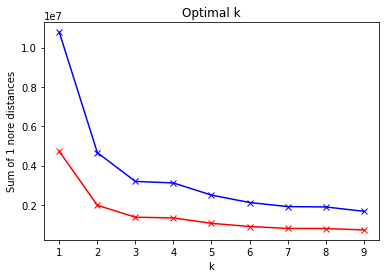

In [95]:
df_kmd = new_df[new_df.columns[~new_df.columns.isin([PROTECTED_VAR, 'prot_binary', TARGET, 'pred'])]]
kmd_train, kmd_test = train_test_split(df_kmd, test_size=0.3)
kmd_train, kmd_test = kmd_train.values, kmd_test.values
sum_1_norm_dist_train = []
sum_1_norm_dist_test = []
K = range(1,10)
for k in K:
    kmedians = K_Medians(k = k)
    kmedians.fit(kmd_train)
    sum_1_norm_dist_train.append(kmedians.sum_of_1_norm_dist)
    tmp_dist = 0
    for i in range(len(kmd_test)):
        tmp_dist += kmedians.pred(kmd_test[i])[0]
    sum_1_norm_dist_test.append(tmp_dist)
    
plt.plot(K, sum_1_norm_dist_train, 'bx-', color='b')
plt.plot(K, sum_1_norm_dist_test, 'bx-', color='r')
plt.xlabel('k')
plt.ylabel('Sum of 1 nore distances')
plt.title('Optimal k')
plt.show() 

In [96]:
N_CLUSTERS = 4

In [97]:
kmedians = K_Medians(k = N_CLUSTERS)
kmedians.fit(df_kmd.values)

In [98]:
print('There are {} people in each group.'.format([len(kmedians.classes[i]) for i in range(N_CLUSTERS)]))

There are [426, 509, 322, 379] people in each group.


In [157]:
new_df_with_y['km_class'] = kmedians.groups
new_df_with_y['fairness_gp'] = ""
new_df_with_y['new_pred'] = pred

# new_df_with_y.head()

In [199]:
vars_for_fairness = ['prot_binary', TARGET, 'pred', 'km_class', 'fairness_gp', 'new_pred']
final_df = pd.DataFrame() #creates a new dataframe that's empty
for c in range(N_CLUSTERS):
    data = new_df_with_y[new_df_with_y['km_class'] == c][vars_for_fairness]
    print("group {} has {} data points".format(c, len(data)))
    pp, np = check_fairness(data)
    # original ratio is 0.3576, pp is 0.2634, np is 0.7365
    # goal is 0.5, pp:np = 1:2
    P, Q = 1, 2
    n_p, n_q = 0, 0
    n_data_p = len(data[data['prot_binary'] == 1])
    n_data_q = len(data[data['prot_binary'] == 0])
    for _ in range(len(data)):
        selected_pp = list(data[data['prot_binary'] == 1][data[data['prot_binary'] == 1]["fairness_gp"]==""].sample(n=P).index.values.astype(int))
        selected_np = list(data[data['prot_binary'] == 0][data[data['prot_binary'] == 0]["fairness_gp"]==""].sample(n=Q).index.values.astype(int))
        selected = selected_pp + selected_np
        data.loc[selected, 'fairness_gp'] = "km"+str(c)+"_fg"+str(n_p)+"&"+str(n_q)
        sel_idx = random.choice(selected)
        print(sel_idx)
        if data.loc[sel_idx, 'pred'] == 1:
            data.loc[selected, 'new_pred'] = 1
        display(data.loc[selected, :])
        n_p += P
        n_q += Q
        if n_p + P >= n_data_p - 1 or n_q + Q >= n_data_q - 1:
            print(c, n_p, n_q)
            break
#     display(data)
    final_df = final_df.append(data)
    print("==========================================================================")

group 0 has 426 data points
poor people that receive assistance: 0.0962
people not poor that receive assistance: 0.4155
poor people that do not receive assistance: 0.0516
people not poor that do not receive assistance: 0.4366
----------------------------------------------------------
% of poor receiving assistance: 0.6508
% of not poor receiving assistance: 0.4876
fairgroup: pp is 0.1479, np is 0.8521, ratio is 0.1736
741


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
741,1,1,2,0,km0_fg0&0,2
1285,0,2,1,0,km0_fg0&0,1
1619,0,1,1,0,km0_fg0&0,1


712


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
586,1,1,1,0,km0_fg1&2,1
190,0,1,2,0,km0_fg1&2,1
712,0,1,1,0,km0_fg1&2,1


937


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
935,1,1,1,0,km0_fg2&4,1
937,0,2,2,0,km0_fg2&4,2
1010,0,2,1,0,km0_fg2&4,1


1133


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
68,1,2,1,0,km0_fg3&6,1
1481,0,2,1,0,km0_fg3&6,1
1133,0,2,1,0,km0_fg3&6,1


526


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
22,1,2,2,0,km0_fg4&8,1
888,0,1,1,0,km0_fg4&8,1
526,0,1,1,0,km0_fg4&8,1


1150


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
127,1,1,1,0,km0_fg5&10,1
890,0,1,1,0,km0_fg5&10,1
1150,0,1,2,0,km0_fg5&10,2


276


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
276,1,1,1,0,km0_fg6&12,1
1219,0,1,2,0,km0_fg6&12,1
1109,0,1,1,0,km0_fg6&12,1


1138


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
215,1,1,1,0,km0_fg7&14,1
863,0,2,2,0,km0_fg7&14,1
1138,0,2,1,0,km0_fg7&14,1


1367


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1367,1,1,1,0,km0_fg8&16,1
286,0,1,1,0,km0_fg8&16,1
1606,0,2,2,0,km0_fg8&16,1


1081


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1081,1,2,2,0,km0_fg9&18,2
1067,0,2,2,0,km0_fg9&18,2
513,0,2,2,0,km0_fg9&18,2


196


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
633,1,1,1,0,km0_fg10&20,1
1539,0,1,2,0,km0_fg10&20,1
196,0,1,1,0,km0_fg10&20,1


1307


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1307,1,2,2,0,km0_fg11&22,2
1451,0,2,1,0,km0_fg11&22,1
1341,0,2,2,0,km0_fg11&22,2


551


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1057,1,1,1,0,km0_fg12&24,1
551,0,1,1,0,km0_fg12&24,1
358,0,1,1,0,km0_fg12&24,1


268


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
524,1,1,1,0,km0_fg13&26,1
268,0,1,2,0,km0_fg13&26,2
1385,0,1,1,0,km0_fg13&26,1


260


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
710,1,1,1,0,km0_fg14&28,1
80,0,2,2,0,km0_fg14&28,2
260,0,1,2,0,km0_fg14&28,2


840


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1315,1,1,1,0,km0_fg15&30,1
475,0,2,2,0,km0_fg15&30,1
840,0,2,1,0,km0_fg15&30,1


321


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
365,1,2,2,0,km0_fg16&32,1
321,0,2,1,0,km0_fg16&32,1
929,0,1,1,0,km0_fg16&32,1


416


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
629,1,1,2,0,km0_fg17&34,1
416,0,1,1,0,km0_fg17&34,1
1015,0,1,2,0,km0_fg17&34,1


1011


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1469,1,2,1,0,km0_fg18&36,1
627,0,2,1,0,km0_fg18&36,1
1011,0,1,1,0,km0_fg18&36,1


879


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
992,1,2,1,0,km0_fg19&38,1
1280,0,1,1,0,km0_fg19&38,1
879,0,2,1,0,km0_fg19&38,1


1080


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1173,1,2,1,0,km0_fg20&40,1
882,0,1,1,0,km0_fg20&40,1
1080,0,2,2,0,km0_fg20&40,2


1332


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1321,1,1,1,0,km0_fg21&42,1
1332,0,2,2,0,km0_fg21&42,2
325,0,2,2,0,km0_fg21&42,2


425


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
425,1,2,2,0,km0_fg22&44,2
187,0,1,1,0,km0_fg22&44,1
695,0,2,1,0,km0_fg22&44,1


478


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
545,1,1,2,0,km0_fg23&46,1
11,0,2,1,0,km0_fg23&46,1
478,0,1,1,0,km0_fg23&46,1


550


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
740,1,1,1,0,km0_fg24&48,1
319,0,1,1,0,km0_fg24&48,1
550,0,2,1,0,km0_fg24&48,1


1102


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
728,1,1,1,0,km0_fg25&50,1
1007,0,2,2,0,km0_fg25&50,2
1102,0,2,2,0,km0_fg25&50,2


1327


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
594,1,1,1,0,km0_fg26&52,1
801,0,1,1,0,km0_fg26&52,1
1327,0,2,1,0,km0_fg26&52,1


1055


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
469,1,1,1,0,km0_fg27&54,1
1055,0,1,1,0,km0_fg27&54,1
1235,0,2,2,0,km0_fg27&54,1


422


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1423,1,2,1,0,km0_fg28&56,1
422,0,1,1,0,km0_fg28&56,1
89,0,1,1,0,km0_fg28&56,1


562


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1031,1,2,2,0,km0_fg29&58,1
1263,0,2,2,0,km0_fg29&58,1
562,0,1,1,0,km0_fg29&58,1


1254


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1014,1,2,1,0,km0_fg30&60,1
1518,0,1,1,0,km0_fg30&60,1
1254,0,1,1,0,km0_fg30&60,1


1604


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
134,1,2,1,0,km0_fg31&62,1
87,0,1,1,0,km0_fg31&62,1
1604,0,1,1,0,km0_fg31&62,1


1241


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1241,1,1,1,0,km0_fg32&64,1
415,0,2,1,0,km0_fg32&64,1
440,0,1,2,0,km0_fg32&64,1


962


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
867,1,2,2,0,km0_fg33&66,1
1569,0,2,2,0,km0_fg33&66,1
962,0,1,1,0,km0_fg33&66,1


1621


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1621,1,1,1,0,km0_fg34&68,1
280,0,2,2,0,km0_fg34&68,1
677,0,2,1,0,km0_fg34&68,1


1426


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1426,1,2,1,0,km0_fg35&70,1
1163,0,1,2,0,km0_fg35&70,1
601,0,2,1,0,km0_fg35&70,1


1593


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1593,1,1,1,0,km0_fg36&72,1
95,0,2,1,0,km0_fg36&72,1
12,0,2,1,0,km0_fg36&72,1


926


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
926,1,2,2,0,km0_fg37&74,2
798,0,2,2,0,km0_fg37&74,2
171,0,2,2,0,km0_fg37&74,2


1350


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1350,1,1,1,0,km0_fg38&76,1
1172,0,1,2,0,km0_fg38&76,1
745,0,2,1,0,km0_fg38&76,1


736


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1027,1,1,1,0,km0_fg39&78,1
74,0,2,1,0,km0_fg39&78,1
736,0,2,2,0,km0_fg39&78,2


1204


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1521,1,1,1,0,km0_fg40&80,1
1204,0,2,2,0,km0_fg40&80,2
529,0,1,1,0,km0_fg40&80,1


1302


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1005,1,2,2,0,km0_fg41&82,2
1302,0,2,2,0,km0_fg41&82,2
97,0,2,2,0,km0_fg41&82,2


830


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
830,1,1,1,0,km0_fg42&84,1
1287,0,2,1,0,km0_fg42&84,1
664,0,2,2,0,km0_fg42&84,1


1240


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1240,1,2,1,0,km0_fg43&86,1
557,0,1,2,0,km0_fg43&86,1
351,0,2,1,0,km0_fg43&86,1


392


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
908,1,1,2,0,km0_fg44&88,1
392,0,1,1,0,km0_fg44&88,1
620,0,1,1,0,km0_fg44&88,1


258


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
258,1,1,1,0,km0_fg45&90,1
316,0,1,2,0,km0_fg45&90,1
790,0,1,2,0,km0_fg45&90,1


247


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
759,1,1,2,0,km0_fg46&92,2
165,0,1,2,0,km0_fg46&92,2
247,0,1,2,0,km0_fg46&92,2


701


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1607,1,1,1,0,km0_fg47&94,1
701,0,1,2,0,km0_fg47&94,2
697,0,2,1,0,km0_fg47&94,1


516


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1448,1,1,1,0,km0_fg48&96,1
516,0,1,1,0,km0_fg48&96,1
1029,0,2,1,0,km0_fg48&96,1


1349


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
834,1,2,1,0,km0_fg49&98,1
1500,0,1,1,0,km0_fg49&98,1
1349,0,1,2,0,km0_fg49&98,2


1439


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
120,1,1,1,0,km0_fg50&100,1
810,0,1,2,0,km0_fg50&100,1
1439,0,1,1,0,km0_fg50&100,1


735


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1328,1,1,1,0,km0_fg51&102,1
735,0,1,1,0,km0_fg51&102,1
8,0,2,1,0,km0_fg51&102,1


436


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
436,1,1,2,0,km0_fg52&104,2
1148,0,2,2,0,km0_fg52&104,2
449,0,2,2,0,km0_fg52&104,2


583


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
583,1,1,2,0,km0_fg53&106,2
911,0,1,1,0,km0_fg53&106,1
1304,0,2,1,0,km0_fg53&106,1


1049


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
809,1,1,1,0,km0_fg54&108,1
1049,0,2,1,0,km0_fg54&108,1
1541,0,2,2,0,km0_fg54&108,1


661


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
661,1,1,1,0,km0_fg55&110,1
1376,0,2,2,0,km0_fg55&110,1
57,0,2,2,0,km0_fg55&110,1


958


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
958,1,1,1,0,km0_fg56&112,1
571,0,2,2,0,km0_fg56&112,1
295,0,2,2,0,km0_fg56&112,1


500


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
500,1,1,1,0,km0_fg57&114,1
1329,0,1,2,0,km0_fg57&114,1
1557,0,1,1,0,km0_fg57&114,1


706


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1379,1,1,1,0,km0_fg58&116,1
706,0,2,2,0,km0_fg58&116,2
35,0,1,1,0,km0_fg58&116,1


764


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
517,1,2,2,0,km0_fg59&118,1
764,0,2,1,0,km0_fg59&118,1
394,0,2,1,0,km0_fg59&118,1


479


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
47,1,1,1,0,km0_fg60&120,1
479,0,1,1,0,km0_fg60&120,1
989,0,1,1,0,km0_fg60&120,1


0 61 122
group 1 has 509 data points
poor people that receive assistance: 0.5147
people not poor that receive assistance: 0.2377
poor people that do not receive assistance: 0.1473
people not poor that do not receive assistance: 0.1002
----------------------------------------------------------
% of poor receiving assistance: 0.7774
% of not poor receiving assistance: 0.7035
fairgroup: pp is 0.6621, np is 0.3379, ratio is 0.5104
1186


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
386,1,1,1,1,km1_fg0&0,1
1186,0,1,1,1,km1_fg0&0,1
1090,0,1,1,1,km1_fg0&0,1


1028


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1444,1,1,1,1,km1_fg1&2,1
1208,0,1,1,1,km1_fg1&2,1
1028,0,1,1,1,km1_fg1&2,1


1268


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1268,1,1,1,1,km1_fg2&4,1
88,0,2,1,1,km1_fg2&4,1
566,0,1,1,1,km1_fg2&4,1


998


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
711,1,1,1,1,km1_fg3&6,1
487,0,1,1,1,km1_fg3&6,1
998,0,1,1,1,km1_fg3&6,1


454


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
463,1,1,1,1,km1_fg4&8,1
454,0,1,1,1,km1_fg4&8,1
491,0,1,1,1,km1_fg4&8,1


182


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
182,1,1,1,1,km1_fg5&10,1
980,0,2,1,1,km1_fg5&10,1
943,0,1,1,1,km1_fg5&10,1


1025


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1421,1,1,1,1,km1_fg6&12,1
125,0,1,1,1,km1_fg6&12,1
1025,0,1,1,1,km1_fg6&12,1


1289


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1289,1,1,1,1,km1_fg7&14,1
1629,0,2,1,1,km1_fg7&14,1
1206,0,1,1,1,km1_fg7&14,1


242


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
242,1,1,1,1,km1_fg8&16,1
168,0,1,1,1,km1_fg8&16,1
450,0,1,1,1,km1_fg8&16,1


1065


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1065,1,1,1,1,km1_fg9&18,1
1362,0,2,1,1,km1_fg9&18,1
845,0,1,1,1,km1_fg9&18,1


1253


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
397,1,2,1,1,km1_fg10&20,1
1253,0,1,1,1,km1_fg10&20,1
284,0,1,1,1,km1_fg10&20,1


1270


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1416,1,1,1,1,km1_fg11&22,1
612,0,2,1,1,km1_fg11&22,1
1270,0,1,1,1,km1_fg11&22,1


1095


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
85,1,2,1,1,km1_fg12&24,1
1498,0,2,2,1,km1_fg12&24,1
1095,0,1,1,1,km1_fg12&24,1


1365


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1209,1,1,1,1,km1_fg13&26,1
1365,0,1,1,1,km1_fg13&26,1
1272,0,2,1,1,km1_fg13&26,1


1465


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
945,1,1,1,1,km1_fg14&28,1
1465,0,1,1,1,km1_fg14&28,1
420,0,1,1,1,km1_fg14&28,1


683


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1390,1,1,1,1,km1_fg15&30,1
683,0,2,1,1,km1_fg15&30,1
614,0,1,1,1,km1_fg15&30,1


1592


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1054,1,1,1,1,km1_fg16&32,1
1592,0,1,1,1,km1_fg16&32,1
1323,0,2,2,1,km1_fg16&32,1


63


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
933,1,1,1,1,km1_fg17&34,1
63,0,1,2,1,km1_fg17&34,2
1587,0,2,1,1,km1_fg17&34,1


1023


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
335,1,2,1,1,km1_fg18&36,1
1023,0,1,1,1,km1_fg18&36,1
1372,0,1,1,1,km1_fg18&36,1


1538


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
654,1,2,1,1,km1_fg19&38,1
1538,0,1,1,1,km1_fg19&38,1
733,0,1,1,1,km1_fg19&38,1


1032


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
456,1,1,1,1,km1_fg20&40,1
1032,0,1,1,1,km1_fg20&40,1
1278,0,1,1,1,km1_fg20&40,1


856


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
214,1,1,1,1,km1_fg21&42,1
615,0,2,2,1,km1_fg21&42,1
856,0,2,1,1,km1_fg21&42,1


593


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
332,1,1,1,1,km1_fg22&44,1
593,0,1,1,1,km1_fg22&44,1
791,0,1,1,1,km1_fg22&44,1


547


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
547,1,2,1,1,km1_fg23&46,1
241,0,1,1,1,km1_fg23&46,1
1485,0,1,1,1,km1_fg23&46,1


1413


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
609,1,1,1,1,km1_fg24&48,1
1413,0,1,1,1,km1_fg24&48,1
1450,0,1,1,1,km1_fg24&48,1


1620


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1620,1,2,1,1,km1_fg25&50,1
1019,0,2,1,1,km1_fg25&50,1
533,0,1,1,1,km1_fg25&50,1


1282


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1282,1,1,1,1,km1_fg26&52,1
1326,0,1,1,1,km1_fg26&52,1
803,0,1,1,1,km1_fg26&52,1


1393


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1393,1,1,1,1,km1_fg27&54,1
938,0,1,1,1,km1_fg27&54,1
1458,0,1,1,1,km1_fg27&54,1


24


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
24,1,1,1,1,km1_fg28&56,1
1115,0,1,1,1,km1_fg28&56,1
600,0,1,1,1,km1_fg28&56,1


131


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
131,1,1,1,1,km1_fg29&58,1
812,0,1,1,1,km1_fg29&58,1
1012,0,1,1,1,km1_fg29&58,1


495


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
495,1,1,1,1,km1_fg30&60,1
204,0,1,1,1,km1_fg30&60,1
1632,0,1,1,1,km1_fg30&60,1


1021


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1021,1,1,1,1,km1_fg31&62,1
98,0,1,1,1,km1_fg31&62,1
690,0,1,1,1,km1_fg31&62,1


189


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1496,1,1,1,1,km1_fg32&64,1
189,0,1,1,1,km1_fg32&64,1
576,0,2,1,1,km1_fg32&64,1


1482


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
837,1,1,1,1,km1_fg33&66,1
1482,0,2,1,1,km1_fg33&66,1
709,0,2,1,1,km1_fg33&66,1


427


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
602,1,1,1,1,km1_fg34&68,1
346,0,1,1,1,km1_fg34&68,1
427,0,1,1,1,km1_fg34&68,1


967


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
84,1,1,1,1,km1_fg35&70,1
967,0,1,1,1,km1_fg35&70,1
821,0,1,1,1,km1_fg35&70,1


1290


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1290,1,1,1,1,km1_fg36&72,1
1344,0,1,1,1,km1_fg36&72,1
1299,0,1,1,1,km1_fg36&72,1


405


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
356,1,1,1,1,km1_fg37&74,1
405,0,1,1,1,km1_fg37&74,1
1480,0,1,1,1,km1_fg37&74,1


1136


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1277,1,1,1,1,km1_fg38&76,1
1136,0,1,1,1,km1_fg38&76,1
667,0,1,2,1,km1_fg38&76,1


630


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
630,1,1,1,1,km1_fg39&78,1
265,0,1,1,1,km1_fg39&78,1
239,0,2,1,1,km1_fg39&78,1


122


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
122,1,1,1,1,km1_fg40&80,1
977,0,2,1,1,km1_fg40&80,1
724,0,2,1,1,km1_fg40&80,1


13


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
195,1,1,1,1,km1_fg41&82,1
434,0,1,2,1,km1_fg41&82,1
13,0,2,1,1,km1_fg41&82,1


46


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1516,1,2,1,1,km1_fg42&84,1
671,0,1,1,1,km1_fg42&84,1
46,0,1,2,1,km1_fg42&84,2


288


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1596,1,1,1,1,km1_fg43&86,1
288,0,2,1,1,km1_fg43&86,1
1233,0,1,1,1,km1_fg43&86,1


839


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1086,1,1,1,1,km1_fg44&88,1
839,0,1,1,1,km1_fg44&88,1
1039,0,2,1,1,km1_fg44&88,1


360


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
624,1,2,1,1,km1_fg45&90,1
360,0,2,1,1,km1_fg45&90,1
1018,0,1,2,1,km1_fg45&90,1


1119


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1003,1,1,1,1,km1_fg46&92,1
717,0,2,1,1,km1_fg46&92,1
1119,0,2,2,1,km1_fg46&92,2


205


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
205,1,1,1,1,km1_fg47&94,1
1077,0,2,2,1,km1_fg47&94,1
1192,0,2,1,1,km1_fg47&94,1


379


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
379,1,2,1,1,km1_fg48&96,1
366,0,1,1,1,km1_fg48&96,1
1260,0,1,1,1,km1_fg48&96,1


799


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1504,1,2,1,1,km1_fg49&98,1
799,0,1,1,1,km1_fg49&98,1
418,0,1,1,1,km1_fg49&98,1


835


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
835,1,1,1,1,km1_fg50&100,1
485,0,1,1,1,km1_fg50&100,1
1483,0,2,1,1,km1_fg50&100,1


132


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
132,1,1,1,1,km1_fg51&102,1
746,0,1,1,1,km1_fg51&102,1
1412,0,1,1,1,km1_fg51&102,1


55


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1274,1,1,1,1,km1_fg52&104,1
55,0,1,1,1,km1_fg52&104,1
738,0,1,1,1,km1_fg52&104,1


368


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
951,1,1,1,1,km1_fg53&106,1
460,0,1,1,1,km1_fg53&106,1
368,0,1,1,1,km1_fg53&106,1


1553


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1553,1,1,1,1,km1_fg54&108,1
1570,0,1,1,1,km1_fg54&108,1
407,0,1,1,1,km1_fg54&108,1


1120


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
294,1,2,1,1,km1_fg55&110,1
1120,0,1,1,1,km1_fg55&110,1
909,0,2,1,1,km1_fg55&110,1


1549


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1549,1,1,1,1,km1_fg56&112,1
591,0,2,1,1,km1_fg56&112,1
734,0,1,1,1,km1_fg56&112,1


1515


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1515,1,2,1,1,km1_fg57&114,1
984,0,2,1,1,km1_fg57&114,1
312,0,1,1,1,km1_fg57&114,1


1351


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1351,1,1,1,1,km1_fg58&116,1
287,0,2,1,1,km1_fg58&116,1
1265,0,1,1,1,km1_fg58&116,1


1147


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
99,1,1,1,1,km1_fg59&118,1
850,0,1,1,1,km1_fg59&118,1
1147,0,1,1,1,km1_fg59&118,1


995


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
744,1,1,1,1,km1_fg60&120,1
995,0,2,1,1,km1_fg60&120,1
414,0,1,1,1,km1_fg60&120,1


486


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
14,1,1,1,1,km1_fg61&122,1
486,0,2,1,1,km1_fg61&122,1
119,0,1,1,1,km1_fg61&122,1


1144


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
674,1,1,1,1,km1_fg62&124,1
876,0,2,1,1,km1_fg62&124,1
1144,0,2,2,1,km1_fg62&124,2


567


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
844,1,1,1,1,km1_fg63&126,1
675,0,1,1,1,km1_fg63&126,1
567,0,2,1,1,km1_fg63&126,1


1101


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1101,1,1,1,1,km1_fg64&128,1
1234,0,1,1,1,km1_fg64&128,1
1397,0,1,1,1,km1_fg64&128,1


1072


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1072,1,1,1,1,km1_fg65&130,1
753,0,1,1,1,km1_fg65&130,1
1216,0,2,1,1,km1_fg65&130,1


167


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
167,1,1,1,1,km1_fg66&132,1
930,0,1,1,1,km1_fg66&132,1
1198,0,1,1,1,km1_fg66&132,1


502


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
490,1,2,1,1,km1_fg67&134,1
1579,0,1,2,1,km1_fg67&134,1
502,0,1,1,1,km1_fg67&134,1


887


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
969,1,2,1,1,km1_fg68&136,1
887,0,1,1,1,km1_fg68&136,1
645,0,1,1,1,km1_fg68&136,1


34


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
184,1,1,1,1,km1_fg69&138,1
376,0,2,1,1,km1_fg69&138,1
34,0,1,1,1,km1_fg69&138,1


572


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
477,1,1,1,1,km1_fg70&140,1
1513,0,1,1,1,km1_fg70&140,1
572,0,1,1,1,km1_fg70&140,1


194


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
269,1,1,1,1,km1_fg71&142,1
29,0,1,1,1,km1_fg71&142,1
194,0,2,1,1,km1_fg71&142,1


793


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1536,1,1,1,1,km1_fg72&144,1
112,0,1,1,1,km1_fg72&144,1
793,0,1,1,1,km1_fg72&144,1


1026


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
918,1,1,1,1,km1_fg73&146,1
1474,0,1,1,1,km1_fg73&146,1
1026,0,1,1,1,km1_fg73&146,1


387


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
387,1,1,1,1,km1_fg74&148,1
626,0,2,1,1,km1_fg74&148,1
31,0,1,1,1,km1_fg74&148,1


108


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
108,1,1,1,1,km1_fg75&150,1
1074,0,2,1,1,km1_fg75&150,1
483,0,1,1,1,km1_fg75&150,1


306


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1373,1,1,1,1,km1_fg76&152,1
1298,0,1,1,1,km1_fg76&152,1
306,0,2,1,1,km1_fg76&152,1


1430


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1430,1,1,1,1,km1_fg77&154,1
1311,0,1,1,1,km1_fg77&154,1
1507,0,2,1,1,km1_fg77&154,1


1464


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1464,1,1,1,1,km1_fg78&156,1
5,0,2,2,1,km1_fg78&156,1
915,0,2,1,1,km1_fg78&156,1


1558


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1441,1,1,1,1,km1_fg79&158,1
1213,0,1,1,1,km1_fg79&158,1
1558,0,1,1,1,km1_fg79&158,1


423


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
948,1,1,1,1,km1_fg80&160,1
423,0,2,1,1,km1_fg80&160,1
1099,0,1,1,1,km1_fg80&160,1


1114


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1573,1,1,1,1,km1_fg81&162,1
985,0,1,1,1,km1_fg81&162,1
1114,0,1,1,1,km1_fg81&162,1


1112


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1112,1,1,1,1,km1_fg82&164,1
855,0,2,1,1,km1_fg82&164,1
758,0,1,1,1,km1_fg82&164,1


767


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
767,1,1,1,1,km1_fg83&166,1
49,0,2,1,1,km1_fg83&166,1
369,0,1,1,1,km1_fg83&166,1


313


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1256,1,1,1,1,km1_fg84&168,1
313,0,1,1,1,km1_fg84&168,1
813,0,1,1,1,km1_fg84&168,1


1 85 170
group 2 has 322 data points
poor people that receive assistance: 0.0186
people not poor that receive assistance: 0.1677
poor people that do not receive assistance: 0.0342
people not poor that do not receive assistance: 0.7795
----------------------------------------------------------
% of poor receiving assistance: 0.3529
% of not poor receiving assistance: 0.1770
fairgroup: pp is 0.0528, np is 0.9472, ratio is 0.0557
1266


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
10,1,1,2,2,km2_fg0&0,2
1166,0,2,2,2,km2_fg0&0,2
1266,0,2,2,2,km2_fg0&0,2


565


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1616,1,2,2,2,km2_fg1&2,2
647,0,2,2,2,km2_fg1&2,2
565,0,2,2,2,km2_fg1&2,2


1437


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1437,1,2,2,2,km2_fg2&4,2
795,0,2,2,2,km2_fg2&4,2
1551,0,2,2,2,km2_fg2&4,2


151


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
643,1,2,2,2,km2_fg3&6,2
622,0,2,2,2,km2_fg3&6,2
151,0,2,2,2,km2_fg3&6,2


682


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1348,1,2,2,2,km2_fg4&8,2
682,0,2,2,2,km2_fg4&8,2
1179,0,2,2,2,km2_fg4&8,2


1176


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
778,1,1,2,2,km2_fg5&10,2
1176,0,2,2,2,km2_fg5&10,2
1391,0,2,2,2,km2_fg5&10,2


83


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
152,1,1,2,2,km2_fg6&12,2
409,0,2,2,2,km2_fg6&12,2
83,0,2,2,2,km2_fg6&12,2


990


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
990,1,2,2,2,km2_fg7&14,2
1511,0,2,2,2,km2_fg7&14,2
1446,0,2,2,2,km2_fg7&14,2


1433


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
396,1,1,2,2,km2_fg8&16,2
1433,0,2,2,2,km2_fg8&16,2
208,0,1,2,2,km2_fg8&16,2


1225


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1556,1,2,2,2,km2_fg9&18,2
628,0,2,2,2,km2_fg9&18,2
1225,0,1,2,2,km2_fg9&18,2


1191


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
464,1,2,2,2,km2_fg10&20,2
1491,0,2,1,2,km2_fg10&20,1
1191,0,2,2,2,km2_fg10&20,2


252


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
672,1,2,2,2,km2_fg11&22,2
252,0,2,2,2,km2_fg11&22,2
124,0,2,2,2,km2_fg11&22,2


655


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1366,1,1,2,2,km2_fg12&24,2
1244,0,2,2,2,km2_fg12&24,2
655,0,2,2,2,km2_fg12&24,2


1431


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
739,1,2,2,2,km2_fg13&26,2
1431,0,2,2,2,km2_fg13&26,2
823,0,2,2,2,km2_fg13&26,2


1006


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1006,1,2,2,2,km2_fg14&28,2
581,0,2,2,2,km2_fg14&28,2
632,0,2,2,2,km2_fg14&28,2


2 15 30
group 3 has 379 data points
poor people that receive assistance: 0.0106
people not poor that receive assistance: 0.3826
poor people that do not receive assistance: 0.0264
people not poor that do not receive assistance: 0.5805
----------------------------------------------------------
% of poor receiving assistance: 0.2857
% of not poor receiving assistance: 0.3973
fairgroup: pp is 0.0369, np is 0.9631, ratio is 0.0384
1436


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1436,1,2,2,3,km3_fg0&0,2
625,0,2,2,3,km3_fg0&0,2
470,0,2,2,3,km3_fg0&0,2


1477


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
400,1,2,2,3,km3_fg1&2,2
1477,0,2,2,3,km3_fg1&2,2
1044,0,1,1,3,km3_fg1&2,1


343


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
246,1,1,1,3,km3_fg2&4,1
343,0,2,2,3,km3_fg2&4,2
838,0,2,2,3,km3_fg2&4,2


959


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
959,1,1,1,3,km3_fg3&6,1
4,0,2,2,3,km3_fg3&6,1
1554,0,1,2,3,km3_fg3&6,1


1478


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1159,1,2,2,3,km3_fg4&8,1
1478,0,1,1,3,km3_fg4&8,1
957,0,1,1,3,km3_fg4&8,1


33


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1517,1,1,2,3,km3_fg5&10,2
33,0,1,2,3,km3_fg5&10,2
220,0,2,2,3,km3_fg5&10,2


170


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
170,1,2,2,3,km3_fg6&12,2
679,0,1,2,3,km3_fg6&12,2
79,0,2,2,3,km3_fg6&12,2


455


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1506,1,1,2,3,km3_fg7&14,2
455,0,2,2,3,km3_fg7&14,2
1352,0,1,2,3,km3_fg7&14,2


1211


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
1211,1,2,2,3,km3_fg8&16,2
1168,0,1,2,3,km3_fg8&16,2
329,0,1,2,3,km3_fg8&16,2


816


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
847,1,2,2,3,km3_fg9&18,2
1226,0,2,2,3,km3_fg9&18,2
816,0,2,2,3,km3_fg9&18,2


589


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
641,1,2,2,3,km3_fg10&20,2
589,0,2,2,3,km3_fg10&20,2
1194,0,2,2,3,km3_fg10&20,2


1283


,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
26,1,2,2,3,km3_fg11&22,2
1283,0,2,2,3,km3_fg11&22,2
328,0,2,2,3,km3_fg11&22,2


3 12 24


In [193]:
pd.DataFrame(final_df['fairness_gp'].value_counts().reset_index())

,index,fairness_gp
0,,1117
1,km1_fg49&98,3
2,km0_fg42&84,3
3,km1_fg34&68,3
4,km0_fg15&30,3
5,km1_fg59&118,3
6,km2_fg0&0,3
7,km1_fg17&34,3
8,km1_fg76&152,3
9,km0_fg41&82,3


In [196]:
final_df

,prot_binary,HINS4,pred,km_class,fairness_gp,new_pred
8,0,2,1,0,,1
9,0,1,1,0,,1
11,0,2,1,0,km0_fg53&106,1
12,0,2,1,0,,1
15,0,2,1,0,km0_fg44&88,1
18,0,1,2,0,km0_fg25&50,1
22,1,2,2,0,km0_fg43&86,1
23,0,2,2,0,,2
25,0,1,1,0,,1
35,0,1,1,0,km0_fg46&92,1


In [197]:
print('Accurary : {}'.format(metrics.accuracy_score(final_df[TARGET], final_df['new_pred'])))
print('Precision : {}'.format(metrics.precision_score(final_df[TARGET], final_df['new_pred'])))
print('Recall : {}'.format(metrics.recall_score(final_df[TARGET], final_df['new_pred'])))
print('F1 score : {}'.format(metrics.f1_score(final_df[TARGET], final_df['new_pred'])))

Accurary : 0.6754278728606357
Precision : 0.6597938144329897
Recall : 0.7111111111111111
F1 score : 0.6844919786096256


In [178]:
# baseline
# Accurary : 0.6858190709046454
# Precision : 0.6796116504854369
# Recall : 0.691358024691358
# F1 score : 0.6854345165238678

In [198]:
_, _ = check_fairness(final_df)

poor people that receive assistance: 0.1913
people not poor that receive assistance: 0.3038
poor people that do not receive assistance: 0.0721
people not poor that do not receive assistance: 0.4328
----------------------------------------------------------
% of poor receiving assistance: 0.7262
% of not poor receiving assistance: 0.4124
fairgroup: pp is 0.2634, np is 0.7366, ratio is 0.3577


In [180]:
# baseline
# poor people that receive assistance: 0.2335
# people not poor that receive assistance: 0.2702
# poor people that do not receive assistance: 0.0300
# people not poor that do not receive assistance: 0.4664
# ----------------------------------------------------------
# % of poor receiving assistance: 0.8863
# % of not poor receiving assistance: 0.3668
# fairgroup: pp is 0.2634, np is 0.7366, ratio is 0.3577